In [43]:
import os
import re
import json

import matplotlib.pyplot as plt

from src.utils.load_files import load_classes, ROOT

In [4]:
classes = load_classes(os.path.join(ROOT, "data", "classes", "classes.json"))

In [ ]:
classes = {label: classes[label]["id"] for label in classes}
with open(os.path.join(ROOT, "data", "classes", "classes_simple.json"), "w+") as f:
    json.dump(classes, f, indent=6)

In [6]:
labels = [label for label in classes]
len(labels)

402

In [10]:
labels[2]

'regulatory--keep-right--g1'

In [23]:
primary_class_pattern = re.compile(r"(\w+--[\w-]+)--\w+")
sub_class_pattern = re.compile(r"\w+--[\w-]+--(\w+)")
labels_with_primary = [label for label in labels if re.findall(primary_class_pattern, label)]
len(labels_with_primary)

400

In [22]:
primary_classes = list(set([re.findall(primary_class_pattern, label)[0] for label in labels_with_primary]))
len(primary_classes)

256

In [51]:
primary_with_subclasses = {}
for primary in primary_classes:
    primary_with_subclasses[primary] = []
    for label in labels_with_primary:
        if primary in label:
            sub_class = re.findall(sub_class_pattern, label)
            primary_with_subclasses[primary].append(sub_class)
len(primary_with_subclasses)           

256

In [52]:
next(iter(primary_with_subclasses.items()))

('information--interstate-route', [['g1']])

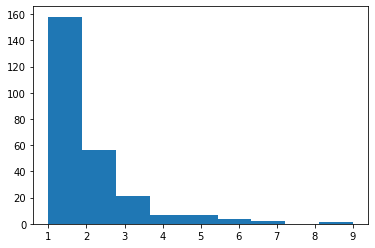

In [53]:
count = [len(elm) for elm in primary_with_subclasses.values()]

plt.hist(count, bins=max(count))
plt.show()

## Remove Chevron

In [54]:
def remove_class_with(classes_dict, word):
    return {primary: sub for primary,sub in classes_dict.items() if word not in primary}

primary_with_subclasses = remove_class_with(primary_with_subclasses, "chevron")
len(primary_with_subclasses)

253